In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing of data

In [77]:
df = pd.read_csv('../data/film_ratings_1.csv', delimiter=';')

In [78]:
df.head()

,description,genre,rating
0,1987 год. Джордан Белфорт становится брокером ...,"драма,криминал,биография,комедия",7.9
1,Добро пожаловать в Зверополис – современный го...,"мультфильм,комедия,криминал,детектив,приключен...",8.3
2,Американское семейство отправляется из Чикаго ...,"комедия,семейный",8.3
3,"К концу подходит время благоденствия, и лето, ...","фэнтези,драма,боевик,мелодрама,приключения",9.0
4,"Жизнь харизматичного авантюриста, капитана Дже...","фэнтези,боевик,приключения",8.4


In [79]:
# возьмем описание и рейтинг из таблицы

In [80]:
data = df.drop(columns=['genre'])
data.head()

,description,rating
0,1987 год. Джордан Белфорт становится брокером ...,7.9
1,Добро пожаловать в Зверополис – современный го...,8.3
2,Американское семейство отправляется из Чикаго ...,8.3
3,"К концу подходит время благоденствия, и лето, ...",9.0
4,"Жизнь харизматичного авантюриста, капитана Дже...",8.4


### Посмотрим распределение длины описания

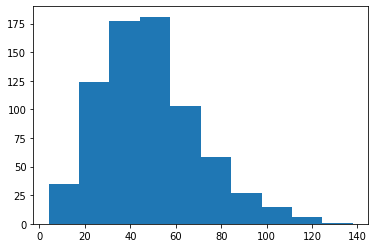

In [81]:
plt.hist(data['description'].apply(lambda x: len(x.split())).values)
plt.show()

Большая часть данных распределена до 100 слов

### А теперь посмотрим как распределен рейтинг

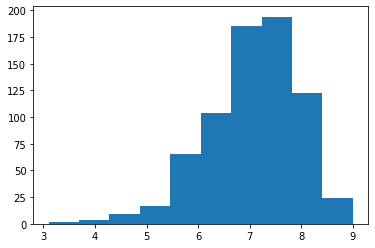

In [82]:
plt.hist(data['rating'].values)
plt.show()

Распределение имеет форму, близкую к нормальному

 # Создаем модель

In [83]:
X = data['description']
y = data['rating']

### baseline - будем использовать предсказание среднего значения

In [84]:
from sklearn.dummy import DummyRegressor

In [85]:
dummy = DummyRegressor()

#### Оценим наш baseline

In [112]:
from sklearn.model_selection import cross_val_score

In [129]:
score = cross_val_score(dummy, X, y, cv=10, scoring='neg_mean_squared_error')

In [130]:
score.mean()

-0.8890957257661487

## preprocessing

В текстах появились ошибки из-за кодировки, так пробел в некоторых местах заменился на "\xa0", исправим это

In [89]:
X[16]

'Двое бандитов Винсент Вега и Джулс Винфилд ведут философские беседы в перерывах между разборками и решением проблем с должниками криминального босса Марселласа Уоллеса.'

In [90]:
X = X.replace('\xa0', ' ')

#### Вторым решением попробуем использовать TF-IDF с классической моделью. Поэтому необходимо предобработать текст: удалить знаки препинаний, нормализовать текст, разбить его на токены.

In [91]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('snowball_data')
nltk.download('perluniprops')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('nonbreaking_prefixes')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package snowball_data to /root/nltk_data...
[nltk_data]   Package snowball_data is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-

True

In [92]:
# токенизация
from nltk.tokenize import word_tokenize

In [93]:
X_tokenized = X.apply(lambda x: word_tokenize(x))

In [94]:
X_tokenized[0][:10]

['1987',
 'год',
 '.',
 'Джордан',
 'Белфорт',
 'становится',
 'брокером',
 'в',
 'успешном',
 'инвестиционном']

In [95]:
# удаление знаков пунктуации
punct = '!"#$%&()*\+,-\./:;<=>?@\[\]^_`{|}~„“«»†*\—/\-‘’'
X_tokenized = X_tokenized.apply(lambda text: [w.strip(punct) for w in text])

In [96]:
# перевод в нижный регистр и удаление пустых строк
X_tokenized = X_tokenized.apply(lambda text: [w.lower() for w in text if w != ''])

In [97]:
X_tokenized[0][:10]

['1987',
 'год',
 'джордан',
 'белфорт',
 'становится',
 'брокером',
 'в',
 'успешном',
 'инвестиционном',
 'банке']

### удалим стоп-слова

In [98]:
from nltk.corpus import stopwords

In [99]:
sw = stopwords.words('russian')

In [100]:
X_tokenized = X_tokenized.apply(lambda text: [w for w in text if w not in sw])

In [101]:
X_tokenized[0][:15]

['1987',
 'год',
 'джордан',
 'белфорт',
 'становится',
 'брокером',
 'успешном',
 'инвестиционном',
 'банке',
 'вскоре',
 'банк',
 'закрывается',
 'внезапного',
 'обвала',
 'индекса']

### Нормализация слов

In [102]:
! pip install pymorphy2

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [103]:
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

In [104]:
X_tokenized = X_tokenized.apply(lambda text: [morph.parse(word)[0].normal_form for word in text])

In [105]:
X_tokenized[0][:10]

['1987',
 'год',
 'джордан',
 'белфорт',
 'становиться',
 'брокер',
 'успешный',
 'инвестиционный',
 'банк',
 'вскоре']

Make model

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [108]:
from sklearn.pipeline import Pipeline

In [118]:
tf_idf_lr = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('lr', LinearRegression())
])

In [127]:
score = cross_val_score(tf_idf_lr, X, y, cv=10, scoring='neg_mean_squared_error')

In [128]:
score.mean()

-0.9004069104481058

Это скор модели без использования наших преобразований. Теперь попробуем исопльзовать наши преобразования

In [131]:
tf_idf_lr = Pipeline([
    ('tf-idf', TfidfVectorizer(preprocessor=' '.join)),
    ('lr', LinearRegression())
])

In [132]:
score = cross_val_score(tf_idf_lr, X_tokenized, y, cv=10, scoring='neg_mean_squared_error')

In [133]:
score.mean()

-0.9328395428184862

Вывод: как мы видим, собранной выборки в 700 не хватает чтобы эффективно обучить модель (обычное усреднение победило ее), а наша нормализация не добавила точности, попробуем использовать более сложную модель - SVM

In [137]:
tf_idf_lr = Pipeline([
    ('tf-idf', TfidfVectorizer(preprocessor=' '.join)),
    ('lr', SVR())
])

In [138]:
score = cross_val_score(tf_idf_lr, X_tokenized, y, cv=10, scoring='neg_mean_squared_error')

In [136]:
score.mean()

-0.8608129151631067

Как мы видим - зависимости в данных нелинейные, поэтому линейная модель не показала хорошего качества, а SVM - дал

In [140]:
tf_idf_lr.fit(X_tokenized, y)

Pipeline(steps=[('tf-idf',
                 TfidfVectorizer(preprocessor=<built-in method join of str object at 0x7fdb99f32930>)),
                ('lr', SVR())])

In [146]:
c = X_tokenized.values[0]

In [148]:
tf_idf_lr.predict([c])

array([7.80009613])

In [149]:
X[0]

'1987 год. Джордан Белфорт становится брокером в успешном инвестиционном банке. Вскоре банк закрывается после внезапного обвала индекса Доу-Джонса. По совету жены Терезы Джордан устраивается в небольшое заведение, занимающееся мелкими акциями. Его настойчивый стиль общения с клиентами и врождённая харизма быстро даёт свои плоды. Он знакомится с соседом по дому Донни, торговцем, который сразу находит общий язык с Джорданом и решает открыть с ним собственную фирму. В качестве сотрудников они нанимают нескольких друзей Белфорта, его отца Макса и называют компанию «Стрэттон Оукмонт». В свободное от работы время Джордан прожигает жизнь: лавирует от одной вечеринки к другой, вступает в сексуальные отношения с проститутками, употребляет множество наркотических препаратов, в том числе кокаин и кваалюд. Однажды наступает момент, когда быстрым обогащением Белфорта начинает интересоваться агент ФБР...'